## Attribute Information:	
1. **loc             :** numeric % McCabe's line count of code
2. **v(g)            :** numeric % McCabe "cyclomatic complexity"
3. **ev(g)           :** numeric % McCabe "essential complexity"
4. **iv(g)           :** numeric % McCabe "design complexity"
5. **n               :** numeric % Halstead total operators + operands
6. **v               :** numeric % Halstead "volume"
7. **l               :** numeric % Halstead "program length"
8. **d               :** numeric % Halstead "difficulty"
9. **e               :** numeric % Halstead "effort"
11. **b               :** numeric % Halstead 
12. **t               :** numeric % Halstead's time estimator
13. **lOCode          :** numeric % Halstead's line count
14. **lOComment       :** numeric % Halstead's count of lines of comments
15. **lOBlank         :** numeric % Halstead's count of blank lines
16. **lOCodeAndComment :** numeric
17. **uniq_Op         :** numeric % unique operators
18. **uniq_Opnd       :** numeric % unique operands
19. **total_Op        :** numeric % total operators
20. **total_Opnd      :** numeric % total operands
21. **branchCount     :** numeric % of the flow graph
22. **defects         :** {false,true} % module has/has not one or more % reported defects

---

## Halstead groups/measures
- **Base measures:**
  - mu1             = number of unique operators
  - mu2             = number of unique operands
  - N1              = total occurrences of operators
  - N2              = total occurrences of operands
  - length     = N  = N1 + N2
  - vocabulary = mu = mu1 + mu2
  - Constants set for each function:
     - mu1' =  2 = potential operator count (just the function name and the "return" operator)
     - mu2'      = potential operand count. (the number of arguments to the module)
  
  **For example, the expression "return max(w+x,x+y)" has "N1=4"
  operators "return, max, +,+)", "N2=4" operands (w,x,x,y),
  "mu1=3" unique operators (return, max,+), and "mu2=3" unique
  operands (w,x,y).**</br></br>  
- **Derived measures:**
    - P = volume = V = N * log2(mu) (the number of mental comparisons needed to write a program of length N)
   - V* = volume on minimal implementation
         = (2 + mu2')*log2(2 + mu2')
   - L  = program length = V*/N
   - D  = difficulty = 1/L
   - L' = 1/D 
   - I  = intelligence = L'*V'
   - E  = effort to write program = V/L 
   - T  = time to write program = E/18 seconds

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [3]:
df = pd.read_csv("../data/raw/jm1.csv")
df

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101758,101758,10.0,2.0,1.0,1.0,28.0,122.98,0.15,6.60,18.63,...,7,0,1,0,11.0,8.0,16.0,12.0,3.0,False
101759,101759,27.0,5.0,4.0,1.0,107.0,559.93,0.06,18.00,34.17,...,23,0,2,0,18.0,20.0,67.0,40.0,9.0,False
101760,101760,26.0,1.0,1.0,1.0,83.0,360.17,0.04,22.75,12.56,...,20,0,4,0,10.0,8.0,51.0,28.0,1.0,False
101761,101761,10.0,2.0,1.0,2.0,43.0,191.76,0.15,6.46,29.53,...,7,0,1,0,11.0,14.0,24.0,19.0,3.0,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 101763 non-null  int64  
 1   loc                101763 non-null  float64
 2   v(g)               101763 non-null  float64
 3   ev(g)              101763 non-null  float64
 4   iv(g)              101763 non-null  float64
 5   n                  101763 non-null  float64
 6   v                  101763 non-null  float64
 7   l                  101763 non-null  float64
 8   d                  101763 non-null  float64
 9   i                  101763 non-null  float64
 10  e                  101763 non-null  float64
 11  b                  101763 non-null  float64
 12  t                  101763 non-null  float64
 13  lOCode             101763 non-null  int64  
 14  lOComment          101763 non-null  int64  
 15  lOBlank            101763 non-null  int64  
 16  lo

In [5]:
df = df.applymap(lambda x: np.nan if x == "?" else x)
for col in df.columns[16:-1]:
    df[col] = df[col].astype(float)

df["defects"] = df["defects"].astype(int)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,101763.0,50881.000000,29376.592059,0.0,25440.50,50881.00,76321.50,101762.00
loc,101763.0,37.347160,54.600401,1.0,13.00,22.00,42.00,3442.00
v(g),101763.0,5.492684,7.900855,1.0,2.00,3.00,6.00,404.00
ev(g),101763.0,2.845022,4.631262,1.0,1.00,1.00,3.00,165.00
iv(g),101763.0,3.498826,5.534541,1.0,1.00,2.00,4.00,402.00
n,101763.0,96.655995,171.147191,0.0,25.00,51.00,111.00,8441.00
v,101763.0,538.280956,1270.791601,0.0,97.67,232.79,560.25,80843.08
l,101763.0,0.111634,0.100096,0.0,0.05,0.09,0.15,1.00
d,101763.0,13.681881,14.121306,0.0,5.60,9.82,18.00,418.20
i,101763.0,27.573007,22.856742,0.0,15.56,23.36,34.34,569.78


## Feature Engineering

In [21]:
df["complex_by_line"] = (df["v(g)"] + df["ev(g)"] + df["iv(g)"]) / df["loc"]
df["complex_by_branch"] = (df["v(g)"] + df["ev(g)"] + df["iv(g)"]) / df["branchCount"]
df["op_opnd"] = abs(df["uniq_Op"] - (df["uniq_Opnd"] * df["total_Op"]) // df["total_Opnd"]) % 2
df["uniq_OpOpnd"] = df["uniq_Op"] + df["uniq_Opnd"]
df["code_by_cmtblank"] = df["lOCode"] / (df["lOComment"] + df["lOBlank"])
df["lines"] = (df["loc"] + df["lOCode"]) / 2
df["Opratio"] = df["total_Op"] / df["uniq_Op"]
df["Opndratio"] = df["total_Opnd"] / df["uniq_Opnd"]
df.drop(["id", "n", "locCodeAndComment", "loc", "lOCode", "uniq_Op", "uniq_Opnd", "total_Op", "total_Opnd"], axis=1, inplace=True)

df.fillna(0, inplace=True)
df = df.replace(np.inf, 0)

KeyError: 'loc'

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
v(g),101763.0,5.492684,7.900855,1.000000,2.000000,3.000000,6.000000,4.040000e+02
ev(g),101763.0,2.845022,4.631262,1.000000,1.000000,1.000000,3.000000,1.650000e+02
iv(g),101763.0,3.498826,5.534541,1.000000,1.000000,2.000000,4.000000,4.020000e+02
v,101763.0,538.280956,1270.791601,0.000000,97.670000,232.790000,560.250000,8.084308e+04
l,101763.0,0.111634,0.100096,0.000000,0.050000,0.090000,0.150000,1.000000e+00
d,101763.0,13.681881,14.121306,0.000000,5.600000,9.820000,18.000000,4.182000e+02
i,101763.0,27.573007,22.856742,0.000000,15.560000,23.360000,34.340000,5.697800e+02
e,101763.0,20853.589876,190571.405427,0.000000,564.730000,2256.230000,10193.240000,1.684662e+07
b,101763.0,0.179164,0.421844,0.000000,0.030000,0.080000,0.190000,2.695000e+01
t,101763.0,1141.357982,9862.795472,0.000000,31.380000,125.400000,565.920000,9.359234e+05


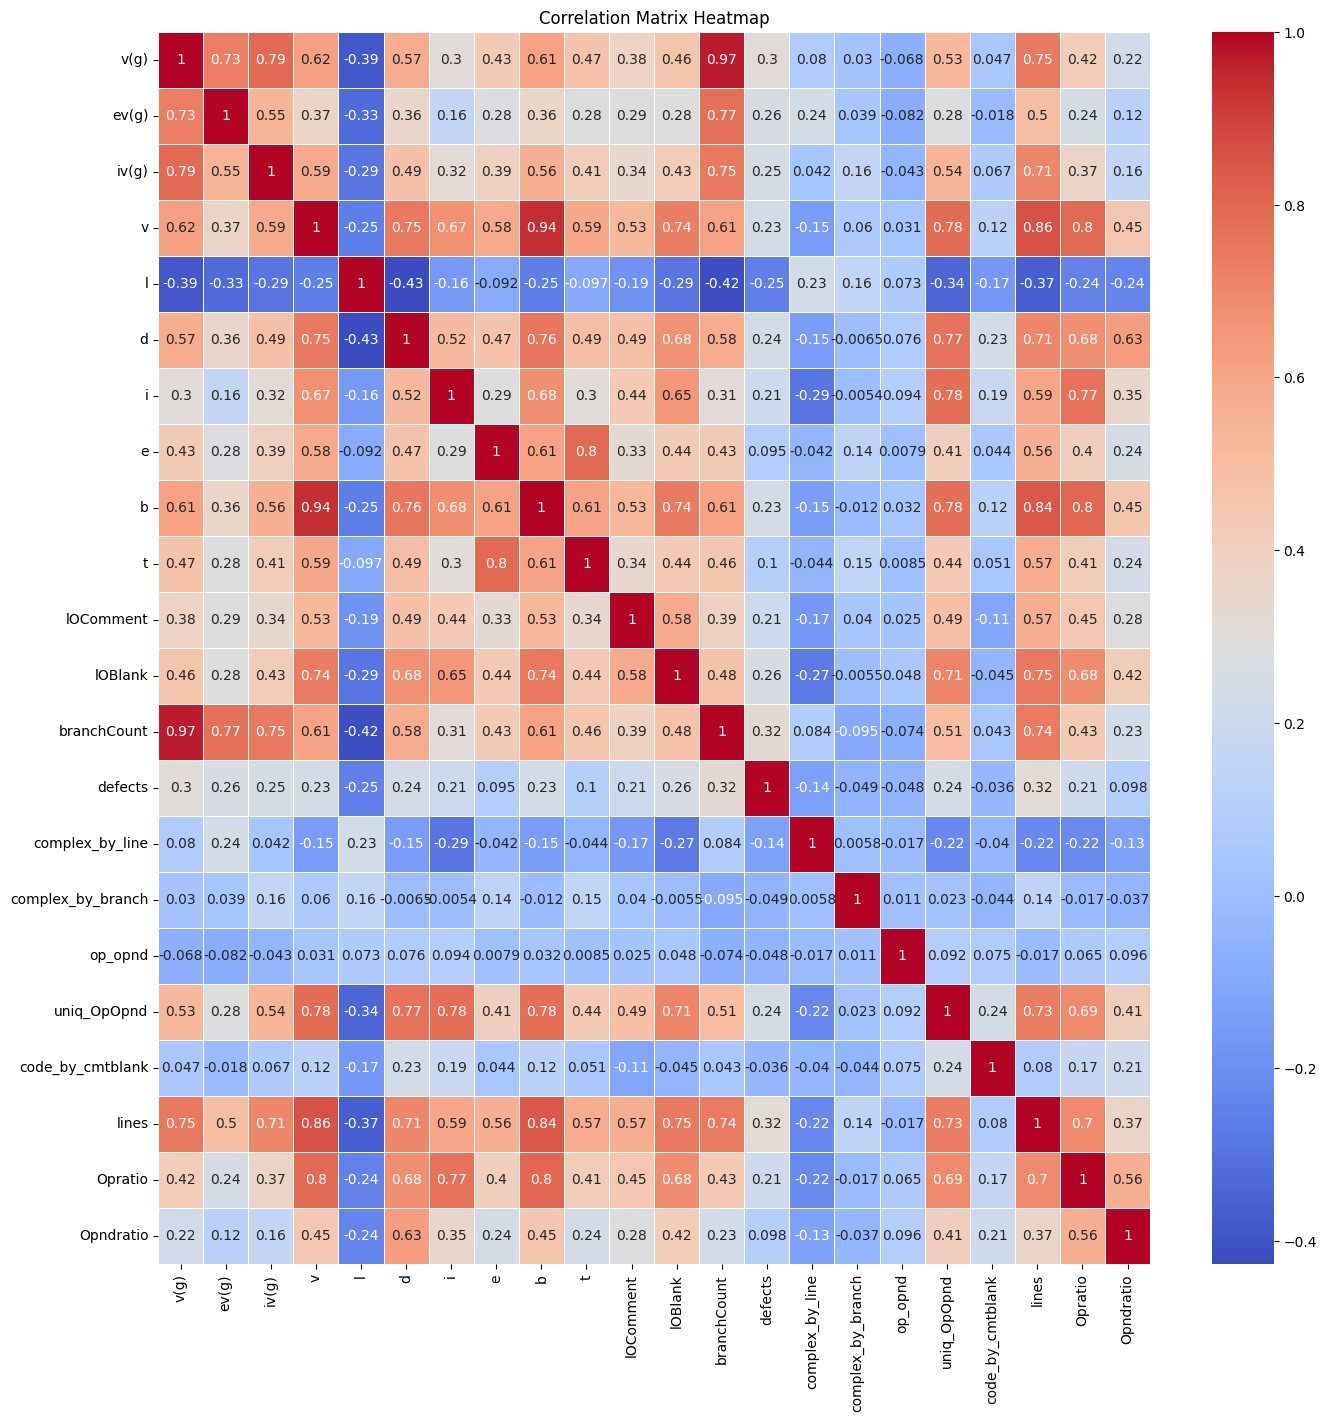

In [9]:
corr_matrix = df.corr()

plt.figure(figsize=(16, 16))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

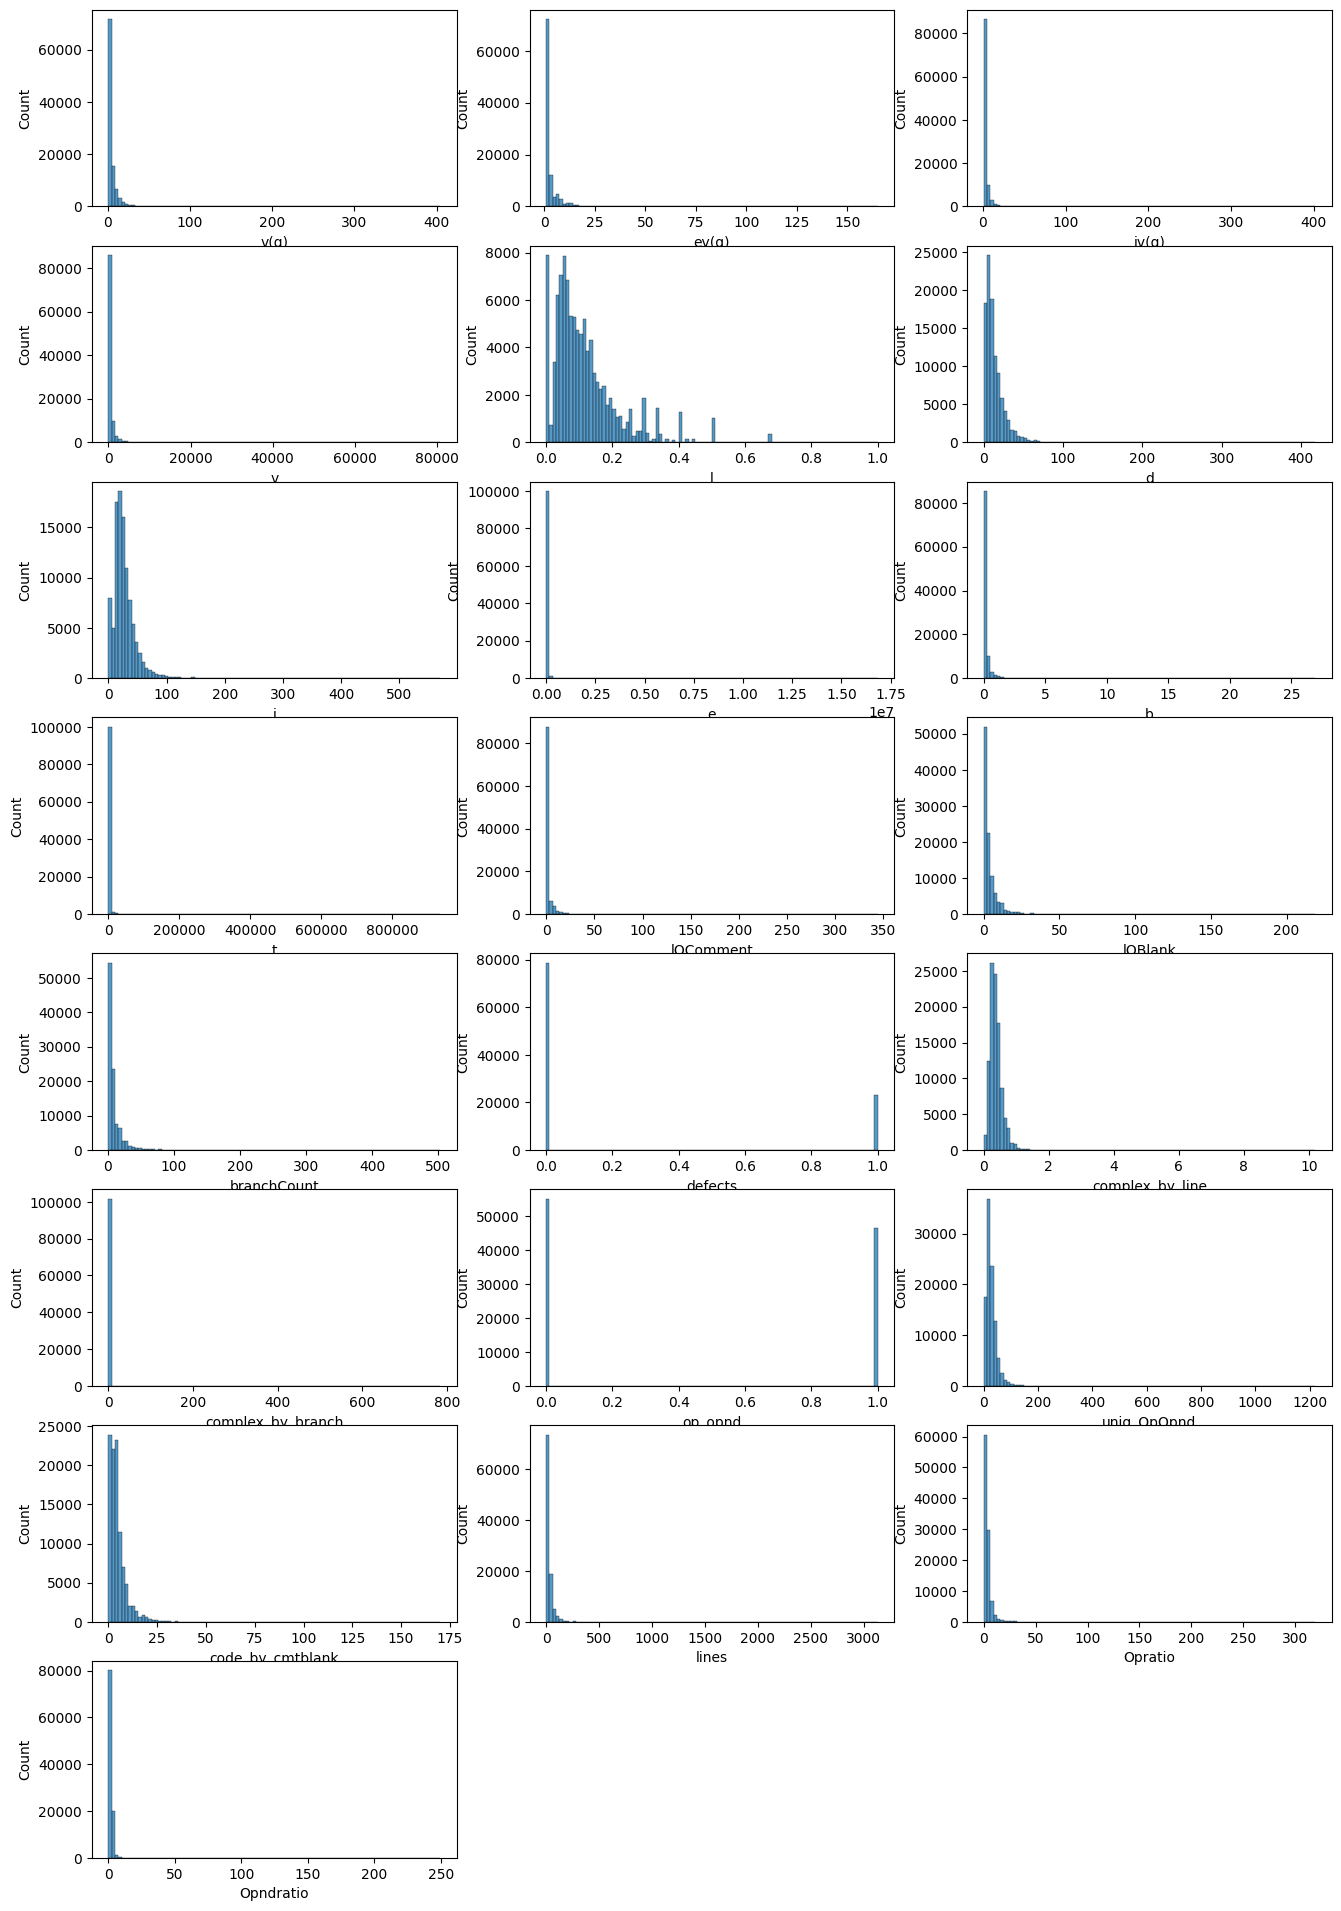

In [10]:
i = 1
plt.figure(figsize=(16, 24))
for c in df.columns:
    plt.subplot(df.drop(["defects"], axis=1).shape[1] // 3 + 1, 3, i)
    sns.histplot(x=df[c], bins=100)
    plt.xlabel = c
    i += 1

## Define scaling and transformation

In [11]:
class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in X.columns:
            X[column] = boxcox(X[column] + 1)[0]
        return X

In [12]:
boxcox_transformer = BoxCoxTransformer()
std_scaler = StandardScaler()

In [13]:
artifacts = {}

## Logistic Regression

In [14]:
import optuna
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score


# Define an objective function to optimize
def objective(trial):
    # Load the Iris dataset
    X, y = df.drop(["defects"], axis=1), df["defects"]
    X = boxcox_transformer.transform(X)
    X_ss = std_scaler.fit_transform(X)
    X = pd.DataFrame(X_ss, columns=X.columns)
    # Define hyperparameters to optimize
    C = trial.suggest_float("C", 0.7, 1)
    solver = trial.suggest_categorical("solver", ["liblinear", "newton-cholesky", "saga"])
    max_iter = trial.suggest_int("max_iter", 50, 150, step=50)

    # Create a random forest classifier with suggested hyperparameters
    model = LogisticRegression(C=C, solver=solver, max_iter=max_iter)

    # Perform stratified k-fold cross-validation with train-test splits
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Adjust n_splits and other parameters as needed
    scores = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)

    # Calculate the mean accuracy
    mean_roc_auc_score = np.mean(scores)

    return mean_roc_auc_score


# Create an Optuna study
study = optuna.create_study(direction="maximize")

# Optimize the objective function
study.optimize(objective, n_trials=25)

# Print the best hyperparameters and their corresponding loss (1 - accuracy)
best_params = study.best_params
best_roc_auc_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_roc_auc_score)

logreg_artifacts = {"hyperparameters": best_params, "roc_auc_score": best_roc_auc_score}

artifacts["LogisticRegression"] = logreg_artifacts

[I 2023-10-23 15:06:15,615] A new study created in memory with name: no-name-4a845cb9-801a-4936-8e49-a1b1e2d17051
[I 2023-10-23 15:06:18,588] Trial 0 finished with value: 0.7855289149219463 and parameters: {'C': 0.9248037189381116, 'solver': 'newton-cholesky', 'max_iter': 50}. Best is trial 0 with value: 0.7855289149219463.
[I 2023-10-23 15:06:24,856] Trial 1 finished with value: 0.785525713469671 and parameters: {'C': 0.8085779856883304, 'solver': 'liblinear', 'max_iter': 50}. Best is trial 0 with value: 0.7855289149219463.
[I 2023-10-23 15:06:30,998] Trial 2 finished with value: 0.7855285165997993 and parameters: {'C': 0.9161079461590792, 'solver': 'liblinear', 'max_iter': 50}. Best is trial 0 with value: 0.7855289149219463.
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWar

Best Hyperparameters: {'C': 0.9999548817461094, 'solver': 'saga', 'max_iter': 150}
Best Accuracy: 0.7855297677610656


## KNeighborsClassifier

In [15]:
import optuna
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score


# Define an objective function to optimize
def objective(trial):
    # Load the Iris dataset
    X, y = df.drop(["defects"], axis=1), df["defects"]
    X = boxcox_transformer.transform(X)
    X_ss = std_scaler.fit_transform(X)
    X = pd.DataFrame(X_ss, columns=X.columns)
    # Define hyperparameters to optimize
    n_neighbors = trial.suggest_int("n_neighbors", 50, 250, 50)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])

    # Create a random forest classifier with suggested hyperparameters
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)

    # Perform stratified k-fold cross-validation with train-test splits
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Adjust n_splits and other parameters as needed
    scores = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)

    # Calculate the mean accuracy
    mean_roc_auc_score = np.mean(scores)

    return mean_roc_auc_score


# Create an Optuna study
study = optuna.create_study(direction="maximize")

# Optimize the objective function
study.optimize(objective, n_trials=10)

# Print the best hyperparameters and their corresponding loss (1 - accuracy)
best_params = study.best_params
best_roc_auc_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_roc_auc_score)

knn_artifacts = {"hyperparameters": best_params, "roc_auc_score": best_roc_auc_score}

artifacts["KNeighborsClassifier"] = knn_artifacts

[I 2023-10-23 15:09:19,832] A new study created in memory with name: no-name-b8848cf5-d75b-405e-87be-8534a14fc9b8
[I 2023-10-23 15:10:00,663] Trial 0 finished with value: 0.7825443069094818 and parameters: {'n_neighbors': 100, 'weights': 'distance'}. Best is trial 0 with value: 0.7825443069094818.
[I 2023-10-23 15:10:46,939] Trial 1 finished with value: 0.776747791632601 and parameters: {'n_neighbors': 50, 'weights': 'distance'}. Best is trial 0 with value: 0.7825443069094818.
[I 2023-10-23 15:11:45,155] Trial 2 finished with value: 0.7857116406616186 and parameters: {'n_neighbors': 200, 'weights': 'uniform'}. Best is trial 2 with value: 0.7857116406616186.
[I 2023-10-23 15:12:39,660] Trial 3 finished with value: 0.7845309072136293 and parameters: {'n_neighbors': 150, 'weights': 'distance'}. Best is trial 2 with value: 0.7857116406616186.
[I 2023-10-23 15:13:41,587] Trial 4 finished with value: 0.7861377445385606 and parameters: {'n_neighbors': 250, 'weights': 'uniform'}. Best is trial

Best Hyperparameters: {'n_neighbors': 250, 'weights': 'uniform'}
Best Accuracy: 0.7861377445385606


## RandomForestClassifier

In [16]:
import optuna
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score


# Define an objective function to optimize
def objective(trial):
    # Load the Iris dataset
    X, y = df.drop(["defects"], axis=1), df["defects"]
    X = boxcox_transformer.transform(X)
    X_ss = std_scaler.fit_transform(X)
    X = pd.DataFrame(X_ss, columns=X.columns)
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 50, 150, step=50)
    max_depth = trial.suggest_int("max_depth", 2, 8, step=2)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)

    # Create a random forest classifier with suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42
    )

    # Perform stratified k-fold cross-validation with train-test splits
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Adjust n_splits and other parameters as needed
    scores = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)

    # Calculate the mean accuracy
    mean_roc_auc_score = np.mean(scores)

    return mean_roc_auc_score


# Create an Optuna study
study = optuna.create_study(direction="maximize")

# Optimize the objective function
study.optimize(objective, n_trials=25)

# Print the best hyperparameters and their corresponding loss (1 - accuracy)
best_params = study.best_params
best_roc_auc_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_roc_auc_score)

rf_artifacts = {"hyperparameters": best_params, "roc_auc_score": best_roc_auc_score}

artifacts["RandomForestClassifier"] = rf_artifacts

[I 2023-10-23 15:18:03,748] A new study created in memory with name: no-name-00b5b78d-c478-4349-a133-e3c6745110d3
[I 2023-10-23 15:18:25,596] Trial 0 finished with value: 0.7839649534226213 and parameters: {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7839649534226213.
[I 2023-10-23 15:18:45,030] Trial 1 finished with value: 0.7893959048305058 and parameters: {'n_estimators': 50, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.7893959048305058.
[I 2023-10-23 15:18:56,499] Trial 2 finished with value: 0.7840354696649158 and parameters: {'n_estimators': 50, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.7893959048305058.
[I 2023-10-23 15:19:51,561] Trial 3 finished with value: 0.7897408137954832 and parameters: {'n_estimators': 150, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.78

Best Hyperparameters: {'n_estimators': 150, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 3}
Best Accuracy: 0.7897408137954832


## LGBMClassifier

In [17]:
# Define an objective function to optimize
def objective(trial):
    # Load the Iris dataset
    X, y = df.drop(["defects"], axis=1), df["defects"]
    X = boxcox_transformer.transform(X)
    X_ss = std_scaler.fit_transform(X)
    X = pd.DataFrame(X_ss, columns=X.columns)
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 50, 150, step=50)
    max_depth = trial.suggest_int("max_depth", 2, 8, step=2)
    lr = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    alpha = trial.suggest_float("reg_alpha", 0.0, 0.3)
    _lambda = trial.suggest_float("reg_lambda", 0.0, 0.2)

    # Create a random forest classifier with suggested hyperparameters
    model = LGBMClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=lr, reg_alpha=alpha, reg_lambda=_lambda, random_state=42)

    # Perform stratified k-fold cross-validation with train-test splits
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Adjust n_splits and other parameters as needed
    scores = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)

    # Calculate the mean accuracy
    mean_roc_auc_score = np.mean(scores)

    return mean_roc_auc_score


# Create an Optuna study
study = optuna.create_study(direction="maximize")

# Optimize the objective function
study.optimize(objective, n_trials=25)

# Print the best hyperparameters and their corresponding loss (1 - accuracy)
best_params = study.best_params
best_roc_auc_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_roc_auc_score)

lgb_artifacts = {"hyperparameters": best_params, "roc_auc_score": best_roc_auc_score}

artifacts["LGBMClassifier"] = lgb_artifacts

[I 2023-10-23 15:33:34,737] A new study created in memory with name: no-name-4be04bde-2a5d-427c-8261-e249f3207326
[I 2023-10-23 15:33:39,925] Trial 0 finished with value: 0.7879502507935405 and parameters: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.00618738853626103, 'reg_alpha': 0.04010736245797882, 'reg_lambda': 0.0031663122596236495}. Best is trial 0 with value: 0.7879502507935405.
[I 2023-10-23 15:33:51,615] Trial 1 finished with value: 0.7889422795376829 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.004098636717712964, 'reg_alpha': 0.20425968881742085, 'reg_lambda': 0.10431704813012249}. Best is trial 1 with value: 0.7889422795376829.
[I 2023-10-23 15:33:56,988] Trial 2 finished with value: 0.7908975677543988 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.07182739673062734, 'reg_alpha': 0.13880692653523163, 'reg_lambda': 0.11269476443995917}. Best is trial 2 with value: 0.7908975677543988.
[I 2023-10-23 15:34:02,076

Best Hyperparameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.06233779034730789, 'reg_alpha': 0.08230570638334737, 'reg_lambda': 0.07346360144698204}
Best Accuracy: 0.7909600836715832


## XGBClassifier

In [18]:
# Define an objective function to optimize
def objective(trial):
    # Load the Iris dataset
    X, y = df.drop(["defects"], axis=1), df["defects"]
    X = boxcox_transformer.transform(X)
    X_ss = std_scaler.fit_transform(X)
    X = pd.DataFrame(X_ss, columns=X.columns)
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 50, 150, step=50)
    max_depth = trial.suggest_int("max_depth", 2, 8, step=2)
    lr = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    gamma = trial.suggest_float("gamma", 0.0, 0.5)
    alpha = trial.suggest_float("reg_alpha", 0.0, 0.3)
    _lambda = trial.suggest_float("reg_lambda", 0.0, 0.2)

    # Create a random forest classifier with suggested hyperparameters
    model = XGBClassifier(
        n_estimators=n_estimators, max_depth=max_depth, learning_rate=lr, gamma=gamma, reg_alpha=alpha, reg_lambda=_lambda, random_state=42
    )

    # Perform stratified k-fold cross-validation with train-test splits
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Adjust n_splits and other parameters as needed
    scores = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)

    # Calculate the mean accuracy
    mean_roc_auc_score = np.mean(scores)

    return mean_roc_auc_score


# Create an Optuna study
study = optuna.create_study(direction="maximize")

# Optimize the objective function
study.optimize(objective, n_trials=25)

# Print the best hyperparameters and their corresponding loss (1 - accuracy)
best_params = study.best_params
best_roc_auc_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_roc_auc_score)

xgb_artifacts = {"hyperparameters": best_params, "roc_auc_score": best_roc_auc_score}

artifacts["XGBClassifier"] = xgb_artifacts

[I 2023-10-23 15:36:21,779] A new study created in memory with name: no-name-6e503ecc-6b95-485a-85d2-5161a1266e57
[I 2023-10-23 15:36:36,920] Trial 0 finished with value: 0.7877052132561241 and parameters: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.016613210473318332, 'gamma': 0.47304971904719395, 'reg_alpha': 0.1528163161526911, 'reg_lambda': 0.048204640071635496}. Best is trial 0 with value: 0.7877052132561241.
[I 2023-10-23 15:38:16,160] Trial 1 finished with value: 0.7889332379555084 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.017153587997958672, 'gamma': 0.24107857719809772, 'reg_alpha': 0.25355800212887203, 'reg_lambda': 0.14330149123075678}. Best is trial 1 with value: 0.7889332379555084.
[I 2023-10-23 15:39:22,095] Trial 2 finished with value: 0.7889576050236006 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.013307112686530847, 'gamma': 0.45013884401755583, 'reg_alpha': 0.21598180683133, 'reg_lambda': 0.1422477

Best Hyperparameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.058164136563391707, 'gamma': 0.4973013816692945, 'reg_alpha': 0.14739820076226484, 'reg_lambda': 0.13029712242700014}
Best Accuracy: 0.7908430711693981


## CatBoostClassifier

In [19]:
# Define an objective function to optimize
def objective(trial):
    # Load the Iris dataset
    X, y = df.drop(["defects"], axis=1), df["defects"]
    X = boxcox_transformer.transform(X)
    X_ss = std_scaler.fit_transform(X)
    X = pd.DataFrame(X_ss, columns=X.columns)
    # Define hyperparameters to optimize
    iterations = trial.suggest_int("iterations", 50, 150, step=50)
    depth = trial.suggest_int("depth", 2, 8, step=2)
    lr = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 2, 32, log=True)

    # Create a random forest classifier with suggested hyperparameters
    model = CatBoostClassifier(iterations=100, depth=depth, min_data_in_leaf=min_data_in_leaf, learning_rate=lr, random_state=42, verbose=0)

    # Perform stratified k-fold cross-validation with train-test splits
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Adjust n_splits and other parameters as needed
    scores = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)

    # Calculate the mean accuracy
    mean_roc_auc_score = np.mean(scores)

    return mean_roc_auc_score


# Create an Optuna study
study = optuna.create_study(direction="maximize")

# Optimize the objective function
study.optimize(objective, n_trials=25)

# Print the best hyperparameters and their corresponding loss (1 - accuracy)
best_params = study.best_params
best_roc_auc_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_roc_auc_score)

catboost_artifacts = {"hyperparameters": best_params, "roc_auc_score": best_roc_auc_score}

artifacts["CatBoostClassifier"] = catboost_artifacts

[I 2023-10-23 15:53:17,765] A new study created in memory with name: no-name-1ebdad96-760d-4a41-a3e1-06db36667cc3
[I 2023-10-23 15:53:29,503] Trial 0 finished with value: 0.7836001407462216 and parameters: {'iterations': 100, 'depth': 8, 'learning_rate': 0.0014082633843921705, 'min_data_in_leaf': 9}. Best is trial 0 with value: 0.7836001407462216.
[I 2023-10-23 15:53:37,704] Trial 1 finished with value: 0.7824350393765077 and parameters: {'iterations': 150, 'depth': 6, 'learning_rate': 0.003926602975167706, 'min_data_in_leaf': 16}. Best is trial 0 with value: 0.7836001407462216.
[I 2023-10-23 15:53:45,798] Trial 2 finished with value: 0.7902853771913717 and parameters: {'iterations': 100, 'depth': 6, 'learning_rate': 0.06889038390579245, 'min_data_in_leaf': 7}. Best is trial 2 with value: 0.7902853771913717.
[I 2023-10-23 15:53:51,314] Trial 3 finished with value: 0.7881156429086711 and parameters: {'iterations': 150, 'depth': 2, 'learning_rate': 0.061789898098963764, 'min_data_in_leaf

Best Hyperparameters: {'iterations': 50, 'depth': 6, 'learning_rate': 0.0933835071726129, 'min_data_in_leaf': 7}
Best Accuracy: 0.7905283008116687


In [20]:
artifacts

{'LogisticRegression': {'hyperparameters': {'C': 0.9999548817461094,
   'solver': 'saga',
   'max_iter': 150},
  'roc_auc_score': 0.7855297677610656},
 'KNeighborsClassifier': {'hyperparameters': {'n_neighbors': 250,
   'weights': 'uniform'},
  'roc_auc_score': 0.7861377445385606},
 'RandomForestClassifier': {'hyperparameters': {'n_estimators': 150,
   'max_depth': 8,
   'min_samples_split': 2,
   'min_samples_leaf': 3},
  'roc_auc_score': 0.7897408137954832},
 'LGBMClassifier': {'hyperparameters': {'n_estimators': 150,
   'max_depth': 4,
   'learning_rate': 0.06233779034730789,
   'reg_alpha': 0.08230570638334737,
   'reg_lambda': 0.07346360144698204},
  'roc_auc_score': 0.7909600836715832},
 'XGBClassifier': {'hyperparameters': {'n_estimators': 150,
   'max_depth': 4,
   'learning_rate': 0.058164136563391707,
   'gamma': 0.4973013816692945,
   'reg_alpha': 0.14739820076226484,
   'reg_lambda': 0.13029712242700014},
  'roc_auc_score': 0.7908430711693981},
 'CatBoostClassifier': {'hype

In [23]:
X, y = df.drop(["defects"], axis=1), df["defects"]
X = boxcox_transformer.transform(X)
X_ss = std_scaler.fit_transform(X)
X = pd.DataFrame(X_ss, columns=X.columns)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df["defects"])

In [24]:
logreg_model = LogisticRegression(**artifacts["LogisticRegression"]["hyperparameters"])
knnclf_model = KNeighborsClassifier(**artifacts["KNeighborsClassifier"]["hyperparameters"])
rfclf_model = RandomForestClassifier(**artifacts["RandomForestClassifier"]["hyperparameters"])
lgbmclf_model = LGBMClassifier(**artifacts["LGBMClassifier"]["hyperparameters"])
xgbclf_model = XGBClassifier(**artifacts["XGBClassifier"]["hyperparameters"])
cbclf_model = CatBoostClassifier(**artifacts["CatBoostClassifier"]["hyperparameters"])

logreg_model.fit(X_train, y_train)
knnclf_model.fit(X_train, y_train)
rfclf_model.fit(X_train, y_train)
lgbmclf_model.fit(X_train, y_train)
xgbclf_model.fit(X_train, y_train)
cbclf_model.fit(X_train, y_train)

val_preds = {}

val_preds["LogisticRegression"] = logreg_model.predict_proba(X_val)[:, 1]
val_preds["KNeighborsClassifier"] = knnclf_model.predict_proba(X_val)[:, 1]
val_preds["RandomForestClassifier"] = rfclf_model.predict_proba(X_val)[:, 1]
val_preds["LGBMClassifier"] = lgbmclf_model.predict_proba(X_val)[:, 1]
val_preds["XGBClassifier"] = xgbclf_model.predict_proba(X_val)[:, 1]
val_preds["CatBoostClassifier"] = cbclf_model.predict_proba(X_val)[:, 1]

0:	learn: 0.6406590	total: 29.6ms	remaining: 1.45s
1:	learn: 0.5999436	total: 53.5ms	remaining: 1.28s
2:	learn: 0.5665943	total: 81.5ms	remaining: 1.28s
3:	learn: 0.5405775	total: 113ms	remaining: 1.3s
4:	learn: 0.5203878	total: 142ms	remaining: 1.27s
5:	learn: 0.5036146	total: 170ms	remaining: 1.24s
6:	learn: 0.4899058	total: 197ms	remaining: 1.21s
7:	learn: 0.4789624	total: 220ms	remaining: 1.16s
8:	learn: 0.4700053	total: 245ms	remaining: 1.11s
9:	learn: 0.4631683	total: 267ms	remaining: 1.07s
10:	learn: 0.4574109	total: 290ms	remaining: 1.03s
11:	learn: 0.4532019	total: 316ms	remaining: 1s
12:	learn: 0.4495296	total: 344ms	remaining: 978ms
13:	learn: 0.4462031	total: 369ms	remaining: 949ms
14:	learn: 0.4437730	total: 393ms	remaining: 917ms
15:	learn: 0.4417527	total: 416ms	remaining: 884ms
16:	learn: 0.4400350	total: 441ms	remaining: 855ms
17:	learn: 0.4385708	total: 469ms	remaining: 834ms
18:	learn: 0.4373041	total: 492ms	remaining: 803ms
19:	learn: 0.4362021	total: 513ms	remainin

In [25]:
val_pred_df = pd.DataFrame(val_preds)

In [26]:
STOP = False
current_best_ensemble = val_pred_df.iloc[:, 0]
MODELS = val_pred_df.iloc[:, 1:]
weight_range = np.arange(0.1, 0.5, 0.01)
history = [roc_auc_score(y_val, current_best_ensemble)]
i = 0

# Hill climbing
while not STOP:
    i += 1
    potential_new_best_cv_score = roc_auc_score(y_val, current_best_ensemble)
    k_best, wgt_best = None, None
    for k in MODELS:
        for wgt in weight_range:
            potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
            cv_score = roc_auc_score(y_val, potential_ensemble)
            if cv_score > potential_new_best_cv_score:
                potential_new_best_cv_score = cv_score
                k_best, wgt_best = k, wgt

    if k_best is not None:
        current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
        MODELS.drop(k_best, axis=1, inplace=True)
        if MODELS.shape[1] == 0:
            STOP = True
        print(f"Iteration: {i}, Model added: {k_best}, Best weight: {wgt_best:.2f}, Best AUC: {potential_new_best_cv_score:.5f}")
        history.append(potential_new_best_cv_score)
    else:
        STOP = True

Iteration: 1, Model added: LGBMClassifier, Best weight: 0.49, Best AUC: 0.79116
Iteration: 2, Model added: XGBClassifier, Best weight: 0.49, Best AUC: 0.79195
Iteration: 3, Model added: KNeighborsClassifier, Best weight: 0.15, Best AUC: 0.79211
Iteration: 4, Model added: RandomForestClassifier, Best weight: 0.10, Best AUC: 0.79212


In [28]:
roc_auc_score(y_val, current_best_ensemble)

0.7921216792166

In [31]:
from sklearn.ensemble import VotingClassifier

votclf = VotingClassifier(
    estimators=[
        ("logreg", logreg_model),
        ("knnclf", knnclf_model),
        ("rfclf", rfclf_model),
        ("lgbmclf", lgbmclf_model),
        ("xgbclf", xgbclf_model),
        ("cbclf", cbclf_model),
    ],
    voting="soft",
)
votclf.fit(X_train, y_train)
val_votclf_preds = votclf.predict_proba(X_val)[:, 1]

In [33]:
roc_auc_score(y_val, val_votclf_preds)

0.7918355286190538

In [34]:
roc_auc_score(y_val, (val_votclf_preds + current_best_ensemble) / 2)

0.7920093234109119